<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/DANN_Moons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch


SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
# !ls -l /content/drive/MyDrive/Research

In [4]:
# !git clone https://github.com/jindongwang/transferlearning.git /content/drive/MyDrive/Research/transferlearning/

In [5]:
from sklearn.datasets import make_moons

In [6]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

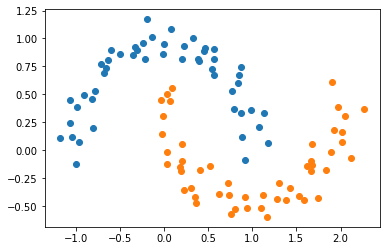

In [7]:
fig, ax = plt.subplots()
ax.scatter(*X[y==0].T)
ax.scatter(*X[y==1].T)
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm


class Model(nn.Module):
    def __init__(self, width):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(2, width)
        self.layer2 = nn.Linear(width, 2)
        self.layer3 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        p = torch.sigmoid(self.layer3(x))[:,0]
        return p


def train_and_validate(model, optimizer, loss_fn, X_train, y_train, X_test, y_test, nepoch):
    """
    """
    losss = []
    accus = []
    ps = []

    for epoch in tqdm.trange(nepoch):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        losss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            bools = ((y_pred>0.5).long() == y_test).type(torch.FloatTensor)
            accus.append(bools.mean())

    return np.array(losss), np.array(accus)



model = Model(5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()


In [9]:
X_ = Variable(torch.from_numpy(X)).float()
y_ = Variable(torch.from_numpy(y)).float()

losss, accus = train_and_validate(model, optimizer, loss_fn, X_, y_, X_, y_, 500)

100%|██████████| 500/500 [00:01<00:00, 275.27it/s]


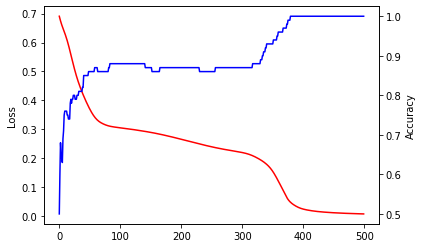

In [10]:
fig, ax = plt.subplots()
ax.plot(losss, color='r')
ax.set_ylabel('Loss')
ax2 = ax.twinx()
ax2.plot(accus, color='b')
ax2.set_ylabel('Accuracy')
plt.show()

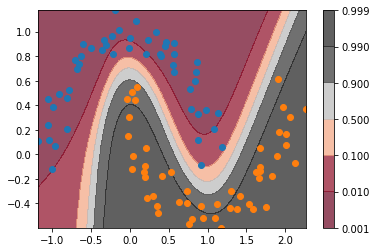

In [11]:
k = 100
x1s = np.linspace(X[:,0].min(), X[:,0].max(), k)
x2s = np.linspace(X[:,1].min(), X[:,1].max(), k)

x1ss, x2ss = np.meshgrid(x1s, x2s)
Xp = np.array(list(zip(x1ss.flatten(), x2ss.flatten())))
Xp_ = Variable(torch.from_numpy(Xp)).float()
zss = model.forward(Xp_).detach().numpy().reshape(k, k)

fig, ax = plt.subplots()
contours = plt.contourf(x1ss, x2ss, zss, [0.001,0.01, 0.1, 0.5, 0.9, 0.99,0.999], cmap='RdGy', alpha=0.7)
# plt.clabel(contours, inline=True, fontsize=12)
plt.colorbar()

ax.scatter(*X[y==0].T)
ax.scatter(*X[y==1].T)

plt.show()

In [12]:
from torch.autograd import Function


class AdversarialLoss(nn.Module):
    def __init__(self, gamma=1.0, max_iter=1000, use_lambda_scheduler=True, **kwargs):  # kwargs not used
        super(AdversarialLoss, self).__init__()
        self.domain_classifier = Discriminator().to(DEVICE)
        self.use_lambda_scheduler = use_lambda_scheduler
        if self.use_lambda_scheduler:
            self.lambda_scheduler = LambdaSheduler(gamma, max_iter)
        
    def forward(self, source, target):
        lamb = 1.0
        if self.use_lambda_scheduler:
            lamb = self.lambda_scheduler.lamb()
            self.lambda_scheduler.step()
        source_loss = self.get_adversarial_result(source, True, lamb)
        target_loss = self.get_adversarial_result(target, False, lamb)
        adv_loss = 0.5 * (source_loss + target_loss)
        return adv_loss
    
    def get_adversarial_result(self, x, source=True, lamb=1.0):
        x = ReverseLayerF.apply(x, lamb)
        domain_pred = self.domain_classifier(x)
        device = domain_pred.device
        if source:
            domain_label = torch.ones(len(x), 1).long()
        else:
            domain_label = torch.zeros(len(x), 1).long()
        loss_fn = nn.BCELoss()
        loss_adv = loss_fn(domain_pred, domain_label.float().to(device))
        return loss_adv
    
    
class LambdaSheduler(nn.Module):
    def __init__(self, gamma=1.0, max_iter=1000, **kwargs):  # kwargs not used
        super(LambdaSheduler, self).__init__()
        self.gamma = gamma
        self.max_iter = max_iter
        self.curr_iter = 0

    def lamb(self):
        p = self.curr_iter / self.max_iter
        lamb = 2. / (1. + np.exp(-self.gamma * p)) - 1
        return lamb
    
    def step(self):
        self.curr_iter = min(self.curr_iter + 1, self.max_iter)


class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None


class Discriminator(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Sigmoid()
        ]
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [13]:
class TransferNet(nn.Module):
    # use_bottleneck?

    def __init__(self, num_class=2, base_net='resnet50', transfer_loss='dann', 
                 use_bottleneck=True, bottleneck_width=256, width=1024):
        super(TransferNet, self).__init__()
        self.base_network = backbone.network_dict[base_net]()
        self.use_bottleneck = use_bottleneck
        self.transfer_loss = transfer_loss
        self.n_class = num_class

        bottleneck_list = [nn.Linear(self.base_network.output_num(), bottleneck_width), 
                           nn.BatchNorm1d(bottleneck_width), 
                           nn.ReLU(), 
                           nn.Dropout(0.5)]
        self.bottleneck_layer = nn.Sequential(*bottleneck_list)

        classifier_layer_list = [nn.Linear(self.base_network.output_num(), width), 
                                 nn.ReLU(), 
                                 nn.Dropout(0.5),
                                 nn.Linear(width, num_class)]
        self.classifier_layer = nn.Sequential(*classifier_layer_list)

        self.bottleneck_layer[0].weight.data.normal_(0, 0.005)
        self.bottleneck_layer[0].bias.data.fill_(0.1)
        for i in range(2):
            self.classifier_layer[i * 3].weight.data.normal_(0, 0.01)
            self.classifier_layer[i * 3].bias.data.fill_(0.0)

        if self.transfer_loss == 'dann':
            self.adv = AdversarialLoss()


    def forward(self, source, target, source_label):
        source = self.base_network(source)
        target = self.base_network(target)
        source_clf = self.classifier_layer(source)
        # target_clf = self.classifier_layer(target)
        # if self.use_bottleneck:
        #     source = self.bottleneck_layer(source)
        #     target = self.bottleneck_layer(target)

        # kwargs = {}
        # kwargs['source_label'] = source_label
        # kwargs['target_logits'] = torch.nn.functional.softmax(target_clf, dim=1)
        transfer_loss = self.adv(source, target)  #, **kwargs)
        return source_clf, transfer_loss


    # predict?
    def predict(self, x):
        features = self.base_network(x)
        clf = self.classifier_layer(features)
        return clf


    def get_optimizer(self, **kwargs):
        """
        """
        lr = kwargs['lr']
        momentum = kwargs['momentum']
        weight_decay = kwargs['weight_decay']

        params = [
            {'params': self.base_network.parameters()},  # retrain base_network (say, resnet) during learning?
            {'params': self.bottleneck_layer.parameters(), 'lr': 10 * lr},
            {'params': self.classifier_layer.parameters(), 'lr': 10 * lr},
        ]

        if self.transfer_loss == 'dann':
            params.append(
                {'params': self.adv.domain_classifier.parameters(), 
                 'lr': 10 * lr})
            
        optimizer = torch.optim.SGD(
            params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        return optimizer

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [15]:
def train(source_loader, target_train_loader, target_test_loader, 
          model, optimizer,
          n_epoch, lamb, early_stop, batchsize):
    len_source_loader = len(source_loader)
    len_target_loader = len(target_train_loader)
    best_acc = 0
    stop = 0
    log = []

    for e in range(n_epoch):
        stop += 1
        train_loss_clf = AverageMeter()
        train_loss_transfer = AverageMeter()
        train_loss_total = AverageMeter()

        model.train()
        iter_source, iter_target = iter(source_loader), iter(target_train_loader)
        n_batch = min(len_source_loader, len_target_loader)
        criterion = torch.nn.CrossEntropyLoss()

        for _ in range(n_batch):
            data_source, label_source = iter_source.next()
            data_target, _ = iter_target.next()
            data_source, label_source = data_source.to(DEVICE), label_source.to(DEVICE)
            data_target = data_target.to(DEVICE)

            # This is not a two-stage training process?
            label_source_pred, transfer_loss = model(data_source, data_target, label_source)
            clf_loss = criterion(label_source_pred, label_source)
            loss = clf_loss + lamb * transfer_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_clf.update(clf_loss.item())
            train_loss_transfer.update(transfer_loss.item())
            train_loss_total.update(loss.item())

        # Test
        acc = test(model, target_test_loader)

        log.append(
            [e, train_loss_clf.avg, train_loss_transfer.avg, train_loss_total.avg, acc.cpu().numpy()])
        # Every epoch save one?
        pd.DataFrame.from_dict(log).to_csv(
            'train_log.csv', header=['Epoch', 'Cls_loss', 'Transfer_loss', 'Total_loss', 'Tar_acc'])
        
        print(f'Epoch: [{e:2d}/{n_epoch}], cls_loss: {train_loss_clf.avg:.4f}, transfer_loss: {train_loss_transfer.avg:.4f}, total_Loss: {train_loss_total.avg:.4f}, acc: {acc:.4f}')
        if best_acc < acc:
            best_acc = acc
            stop = 0
        if stop >= early_stop:
            break
    print('Transfer result: {:.4f}'.format(best_acc))


def test(model, target_test_loader):
    model.eval()
    test_loss = AverageMeter()
    correct = 0
    criterion = torch.nn.CrossEntropyLoss()
    len_target_dataset = len(target_test_loader.dataset)
    with torch.no_grad():
        for data, target in target_test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            s_output = model.predict(data)
            loss = criterion(s_output, target)
            test_loss.update(loss.item())
            pred = torch.max(s_output, 1)[1]
            correct += torch.sum(pred == target)
    acc = 100. * correct / len_target_dataset
    return acc


def load_data(src, tar, root_dir):
    folder_src = os.path.join(root_dir, src)
    folder_tar = os.path.join(root_dir, tar)
    source_loader = data_loader.load_data(
        folder_src, batchsize, True, {'num_workers': 4})
    target_train_loader = data_loader.load_data(
        folder_tar, batchsize, True, {'num_workers': 4})
    target_test_loader = data_loader.load_data(
        folder_tar, batchsize, False, {'num_workers': 4})
    return source_loader, target_train_loader, target_test_loader


In [11]:
src_domain, tar_domain = src, tar

source_loader, target_train_loader, target_test_loader =\
    load_data(src_domain, tar_domain, args.data)

model = models.TransferNet(
    n_class, transfer_loss='dann', base_net=model).to(DEVICE)

optimizer = model.get_optimizer(args)

train(source_loader, target_train_loader,
      target_test_loader, model, optimizer)